# Exploring the data from the Pedestrian Collisions in Calgary

This notebook is to explore the data, and to try to find an idea for the kind of angle we want to take for the project.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme(style="darkgrid")

In [2]:
raw_data = pd.read_csv("data/Traffic_Incidents.csv")

In [3]:
raw_data.head()

,INCIDENT INFO,DESCRIPTION,START_DT,MODIFIED_DT,QUADRANT,Longitude,Latitude,Count,id,Point
0,36 Street and 16 Avenue NE,Traffic incident.,2025/09/20 09:12:13 PM,2025/09/20 09:14:20 PM,NE,-113.989219,51.067086,1,2025-09-20T21:12:1351.06708558268999-113.98921...,POINT (-113.98921902947416 51.06708558268999)
1,Southbound 52 Street and Rundlehorn Drive NE,Two vehicle incident. Blocking the right lane,2025/09/20 09:01:29 PM,2025/09/20 09:14:20 PM,NE,-113.958504,51.071675,1,2025-09-20T21:01:2951.07167451687124-113.95850...,POINT (-113.95850399876483 51.07167451687124)
2,Redstone Boulevard and 128 Avenue NE,Traffic incident.,2025/09/20 08:58:54 PM,2025/09/20 09:14:20 PM,NE,-113.951110,51.165443,1,2025-09-20T20:58:5451.165443375384434-113.9511...,POINT (-113.95111001198308 51.165443375384434)
3,Northbound Deerfoot Trail and McKnight Blvd NE,Traffic incident.,2025/09/20 06:57:37 PM,2025/09/20 07:33:24 PM,NE,-114.047814,51.096147,1,2025-09-20T18:57:3751.09614747992273-114.04781...,POINT (-114.04781390753715 51.09614747992273)
4,Eastbound Glenmore Trail and Stoney Trail SE,Multi-vehicle incident. Blocking the right lane,2025/09/20 06:32:17 PM,2025/09/20 09:14:20 PM,SE,-113.930721,50.979694,1,2025-09-20T18:32:1750.979693814766854-113.9307...,POINT (-113.93072055567782 50.979693814766854)


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56333 entries, 0 to 56332
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   INCIDENT INFO  56333 non-null  object 
 1   DESCRIPTION    56331 non-null  object 
 2   START_DT       56333 non-null  object 
 3   MODIFIED_DT    42276 non-null  object 
 4   QUADRANT       42274 non-null  object 
 5   Longitude      56333 non-null  float64
 6   Latitude       56333 non-null  float64
 7   Count          56333 non-null  int64  
 8   id             56333 non-null  object 
 9   Point          56333 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 4.3+ MB


In [5]:
raw_data.describe()

,Longitude,Latitude,Count
count,56333.000000,56333.000000,56333.0
mean,-114.048977,51.043195,1.0
std,0.071479,0.068297,0.0
min,-114.309770,50.848554,1.0
25%,-114.094709,50.997746,1.0
50%,-114.047750,51.048066,1.0
75%,-113.998779,51.088740,1.0
max,-113.871362,51.198505,1.0


Ok, admittedly, this data is kind of lackluster. Apart from the geographical information, there does not seem to be a lot to work with here. I can maybe try and find some type of results through this, but I will most likely be moving to another dataset soon.

In [6]:
raw_data['DESCRIPTION'].nunique()

6431

Man, what the hell. This means that there are about 6400 different types of descriptions for the traffic incidents.

In [7]:
raw_data['DESCRIPTION'].value_counts().head(25)

DESCRIPTION
Traffic incident.                                                13862
Two vehicle incident.                                             7878
Traffic incident. Blocking the right lane                         2431
Single vehicle incident.                                          2375
Two vehicle incident. Blocking the right lane                     1708
Multi-vehicle incident.                                           1513
Traffic incident. Blocking the left lane                          1243
Two vehicle incident. Blocking the left lane                       964
Traffic incident. Blocking multiple lanes                          656
There is an incident involving a pedestrian.                       651
Multi-vehicle incident. Blocking the right lane                    633
There is an incident involving a pedestrian- EMS on site.          611
Traffic incident.  Blocking the right lane                         537
Multi-vehicle incident. Blocking the left lane                   

Ok, so there is something we can do here. Let's ignore the descriptions that are one-off, and group together all the incidents that are similar. For example, we can group together "Two vehicle incident. Blocking the right lane" and "Two vehicle incident. Blocking the left lane" to just "Two vehicle incident"

### Cleaning and Normalizing Incident Descriptions

The raw `DESCRIPTION` field has over 6,000 unique values, many of which are small variations of the same category.  
For example:
- `Two vehicle incident. Blocking the right lane`
- `Two vehicle incident. Blocking the left lane`
- `2 vehicle incident.`  

All of these should map to **Two vehicle incident**.

To simplify analysis, I grouped the data into the following main categories:
- **Traffic incident**  
- **Two vehicle incident**  
- **Single vehicle incident**  
- **Multi-vehicle incident**  
- **Pedestrian incident**  
- **Stalled vehicle**  
- **Traffic signals flashing red**  
- **Other** (for all remaining, less common descriptions)

I used a rule-based function (string matching) to assign each raw description to one of these categories. Any description not matching one of the main categories is grouped under **Other**.


In [8]:
df = raw_data.copy()

def clean_description(desc):
    if pd.isna(desc):  # handle missing values
        return "Other"
    
    desc = str(desc).lower().strip()

    if "two vehicle incident" in desc or "2 vehicle incident" in desc:
        return "Two vehicle incident"
    elif "single vehicle incident" in desc:
        return "Single vehicle incident"
    elif "multi-vehicle incident" in desc:
        return "Multi-vehicle incident"
    elif "pedestrian" in desc:
        return "Pedestrian incident"
    elif "stalled vehicle" in desc:
        return "Stalled vehicle"
    elif "traffic signals are flashing red" in desc:
        return "Traffic signals flashing red"
    elif "traffic incident" in desc:
        return "Traffic incident"
    else:
        return "Other"

df["DESCRIPTION_CLEAN"] = df["DESCRIPTION"].apply(clean_description)

In [9]:
df.head()

,INCIDENT INFO,DESCRIPTION,START_DT,MODIFIED_DT,QUADRANT,Longitude,Latitude,Count,id,Point,DESCRIPTION_CLEAN
0,36 Street and 16 Avenue NE,Traffic incident.,2025/09/20 09:12:13 PM,2025/09/20 09:14:20 PM,NE,-113.989219,51.067086,1,2025-09-20T21:12:1351.06708558268999-113.98921...,POINT (-113.98921902947416 51.06708558268999),Traffic incident
1,Southbound 52 Street and Rundlehorn Drive NE,Two vehicle incident. Blocking the right lane,2025/09/20 09:01:29 PM,2025/09/20 09:14:20 PM,NE,-113.958504,51.071675,1,2025-09-20T21:01:2951.07167451687124-113.95850...,POINT (-113.95850399876483 51.07167451687124),Two vehicle incident
2,Redstone Boulevard and 128 Avenue NE,Traffic incident.,2025/09/20 08:58:54 PM,2025/09/20 09:14:20 PM,NE,-113.951110,51.165443,1,2025-09-20T20:58:5451.165443375384434-113.9511...,POINT (-113.95111001198308 51.165443375384434),Traffic incident
3,Northbound Deerfoot Trail and McKnight Blvd NE,Traffic incident.,2025/09/20 06:57:37 PM,2025/09/20 07:33:24 PM,NE,-114.047814,51.096147,1,2025-09-20T18:57:3751.09614747992273-114.04781...,POINT (-114.04781390753715 51.09614747992273),Traffic incident
4,Eastbound Glenmore Trail and Stoney Trail SE,Multi-vehicle incident. Blocking the right lane,2025/09/20 06:32:17 PM,2025/09/20 09:14:20 PM,SE,-113.930721,50.979694,1,2025-09-20T18:32:1750.979693814766854-113.9307...,POINT (-113.93072055567782 50.979693814766854),Multi-vehicle incident


In [10]:
df['DESCRIPTION_CLEAN'].value_counts()

DESCRIPTION_CLEAN
Traffic incident                23278
Two vehicle incident            16231
Multi-vehicle incident           5134
Single vehicle incident          3999
Pedestrian incident              2148
Other                            2108
Stalled vehicle                  2103
Traffic signals flashing red     1332
Name: count, dtype: int64

Woah, now we can actually do something! YAY!

In [11]:
df.isna().sum()

INCIDENT INFO            0
DESCRIPTION              2
START_DT                 0
MODIFIED_DT          14057
QUADRANT             14059
Longitude                0
Latitude                 0
Count                    0
id                       0
Point                    0
DESCRIPTION_CLEAN        0
dtype: int64

A lot of missing values in both MODIFIED_DT and QUADRANT. We won't need modified date, we can just use start date. But quadrant is important, so maybe we can derive it with longitude and latitude?

In [12]:
df = df.drop('MODIFIED_DT', axis=1)
df = df.drop('DESCRIPTION', axis=1)

In [13]:
df.head()

,INCIDENT INFO,START_DT,QUADRANT,Longitude,Latitude,Count,id,Point,DESCRIPTION_CLEAN
0,36 Street and 16 Avenue NE,2025/09/20 09:12:13 PM,NE,-113.989219,51.067086,1,2025-09-20T21:12:1351.06708558268999-113.98921...,POINT (-113.98921902947416 51.06708558268999),Traffic incident
1,Southbound 52 Street and Rundlehorn Drive NE,2025/09/20 09:01:29 PM,NE,-113.958504,51.071675,1,2025-09-20T21:01:2951.07167451687124-113.95850...,POINT (-113.95850399876483 51.07167451687124),Two vehicle incident
2,Redstone Boulevard and 128 Avenue NE,2025/09/20 08:58:54 PM,NE,-113.951110,51.165443,1,2025-09-20T20:58:5451.165443375384434-113.9511...,POINT (-113.95111001198308 51.165443375384434),Traffic incident
3,Northbound Deerfoot Trail and McKnight Blvd NE,2025/09/20 06:57:37 PM,NE,-114.047814,51.096147,1,2025-09-20T18:57:3751.09614747992273-114.04781...,POINT (-114.04781390753715 51.09614747992273),Traffic incident
4,Eastbound Glenmore Trail and Stoney Trail SE,2025/09/20 06:32:17 PM,SE,-113.930721,50.979694,1,2025-09-20T18:32:1750.979693814766854-113.9307...,POINT (-113.93072055567782 50.979693814766854),Multi-vehicle incident


In [15]:
df['Count'].nunique()

1

In [16]:
df = df.drop('Count', axis=1)
df = df.drop('id', axis=1)
df = df.drop('Point', axis=1)

In [20]:
df["START_DT"] = pd.to_datetime(df["START_DT"])

/var/folders/qw/y3ys43gs7cdblx18lvtrz8r40000gn/T/ipykernel_5197/2550944546.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["START_DT"] = pd.to_datetime(df["START_DT"])


In [21]:
df.head()

,INCIDENT INFO,START_DT,QUADRANT,Longitude,Latitude,DESCRIPTION_CLEAN
0,36 Street and 16 Avenue NE,2025-09-20 21:12:13,NE,-113.989219,51.067086,Traffic incident
1,Southbound 52 Street and Rundlehorn Drive NE,2025-09-20 21:01:29,NE,-113.958504,51.071675,Two vehicle incident
2,Redstone Boulevard and 128 Avenue NE,2025-09-20 20:58:54,NE,-113.951110,51.165443,Traffic incident
3,Northbound Deerfoot Trail and McKnight Blvd NE,2025-09-20 18:57:37,NE,-114.047814,51.096147,Traffic incident
4,Eastbound Glenmore Trail and Stoney Trail SE,2025-09-20 18:32:17,SE,-113.930721,50.979694,Multi-vehicle incident


In [22]:
def assign_quadrant(lat, lon):
    if pd.isna(lat) or pd.isna(lon):
        return None
    if lat > 51.045:  # North
        if lon > -114.071:
            return "NE"
        else:
            return "NW"
    else:  # South
        if lon > -114.071:
            return "SE"
        else:
            return "SW"

# Apply to the dataframe
df["QUADRANT"] = df.apply(
    lambda row: assign_quadrant(row["Latitude"], row["Longitude"]), axis=1
)


In [23]:
df.isna().sum()

INCIDENT INFO        0
START_DT             0
QUADRANT             0
Longitude            0
Latitude             0
DESCRIPTION_CLEAN    0
dtype: int64

## Let's start looking at the data

In [17]:
df['INCIDENT INFO'].nunique()

23001

In [19]:
df['INCIDENT INFO'].value_counts().head(25)

INCIDENT INFO
Eastbound Glenmore Trail approaching 14 Street SW              129
Southbound Deerfoot Trail approaching Glenmore Trail SE        127
 Southbound Deerfoot Trail approaching Glenmore Trail SE       119
 Eastbound Glenmore Trail approaching 14 Street SW             101
Southbound Crowchild Trail approaching Glenmore Trail SW        87
Westbound Glenmore Trail approaching Crowchild Trail SW         68
Northbound Deerfoot Trail approaching 17 Avenue SE              67
Eastbound Glenmore Trail approaching Deerfoot Trail SE          61
 Northbound Deerfoot Trail and 64 Avenue NE                     60
Eastbound Glenmore Trail approaching Blackfoot Trail SE         57
Eastbound Glenmore Trail at 14 Street SW                        56
Northbound Deerfoot Trail approaching Peigan Trail SE           53
Southbound Deerfoot Trail at Peigan Trail SE                    53
Eastbound Memorial Drive approaching Deerfoot Trail SE          52
Northbound Deerfoot Trail approaching McKnight B

Use the above data to mix and match with geographical mapping to see which type of intersections lead to more accidents.

### Finding trend in terms of seasons
Lets split up the seasons to spring, summer, fall, winter.

In [24]:
def categorize_seasons(date):
    if pd.isna(date):
        return None
    month = date.month
    if month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Fall"
    else:
        return "Winter"

df["SEASON"] = df["START_DT"].apply(categorize_seasons)

In [26]:
df["SEASON"].value_counts()

SEASON
Winter    15702
Fall      15229
Summer    13074
Spring    12328
Name: count, dtype: int64

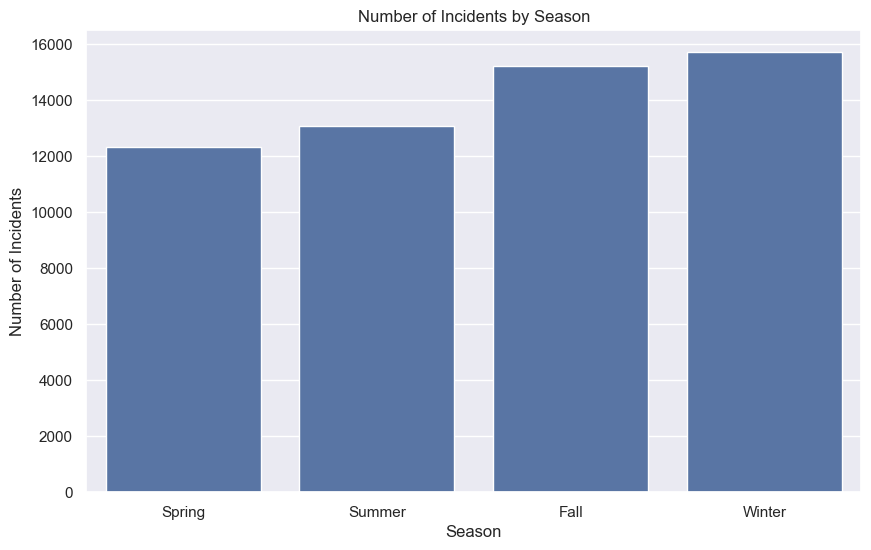

In [29]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="SEASON", order=["Spring", "Summer", "Fall", "Winter"])
plt.title("Number of Incidents by Season")
plt.xlabel("Season")
plt.ylabel("Number of Incidents")
plt.show()

Definite increase in accidents during Fall and Winter, with the most accidents happening in Winter.

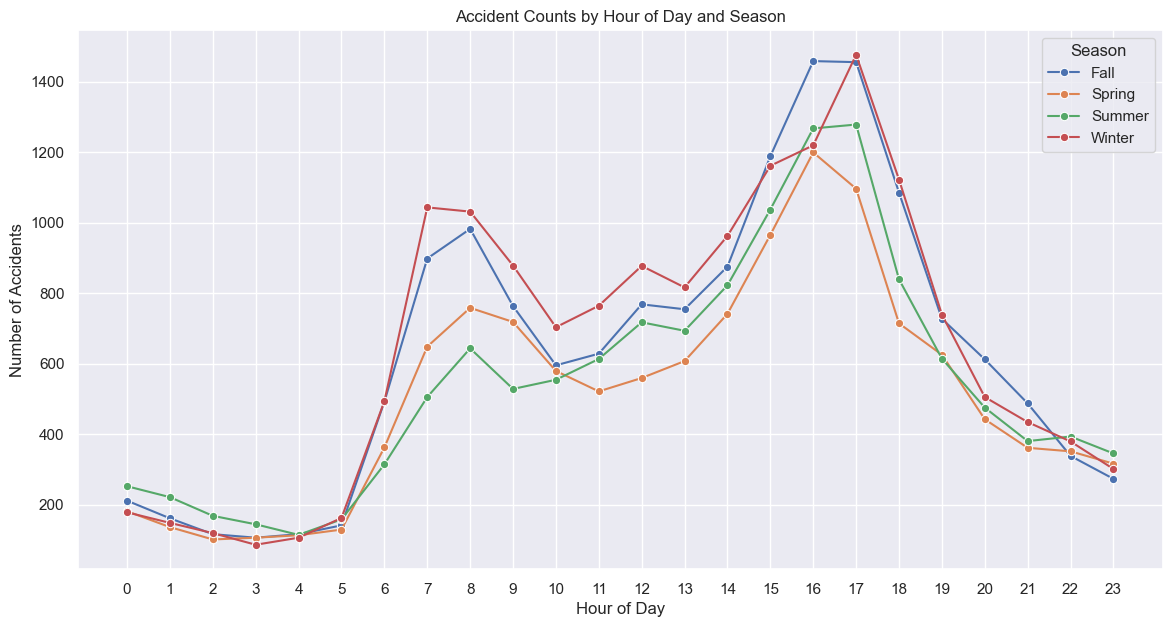

In [32]:
# Extract hour from START_DT
df['HOUR'] = df['START_DT'].dt.hour

# Group by season and hour, count incidents
season_hour_counts = df.groupby(['SEASON', 'HOUR']).size().reset_index(name='INCIDENT_COUNT')

plt.figure(figsize=(14, 7))
sns.lineplot(data=season_hour_counts, x='HOUR', y='INCIDENT_COUNT', hue='SEASON', marker='o')
plt.title('Accident Counts by Hour of Day and Season')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.legend(title='Season')
plt.xticks(range(0, 24))
plt.show()

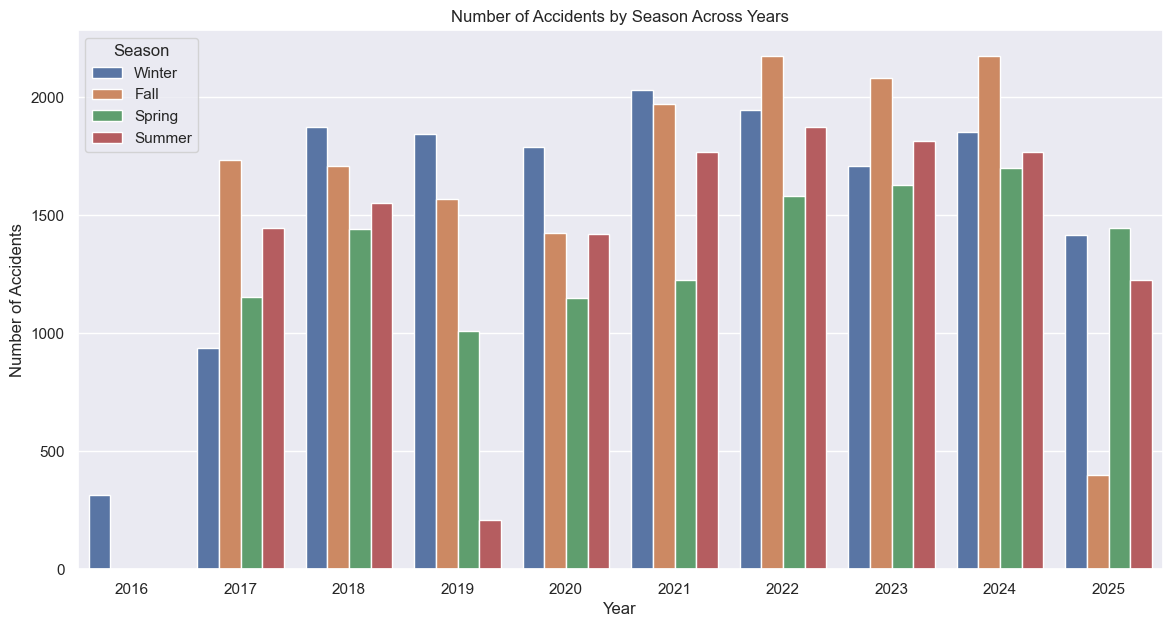

In [33]:
# Extract year from START_DT
df['YEAR'] = df['START_DT'].dt.year

# Group by YEAR and SEASON, count incidents
season_year_counts = df.groupby(['YEAR', 'SEASON']).size().reset_index(name='INCIDENT_COUNT')

plt.figure(figsize=(14, 7))
sns.barplot(data=season_year_counts, x='YEAR', y='INCIDENT_COUNT', hue='SEASON')
plt.title('Number of Accidents by Season Across Years')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.legend(title='Season')
plt.show()

WEEKPART
Weekday    44699
Weekend    11634
Name: count, dtype: int64


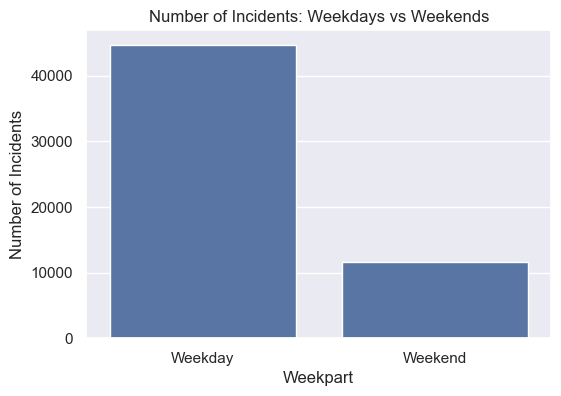

In [34]:
# Add a column for day of week (0=Monday, ..., 6=Sunday)
df['DAY_OF_WEEK'] = df['START_DT'].dt.dayofweek

# Create a new column to indicate Weekday or Weekend
df['WEEKPART'] = df['DAY_OF_WEEK'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Count incidents by Weekday/Weekend
weekpart_counts = df['WEEKPART'].value_counts()

print(weekpart_counts)

# Plot incidents by Weekday vs Weekend
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='WEEKPART', order=['Weekday', 'Weekend'])
plt.title('Number of Incidents: Weekdays vs Weekends')
plt.xlabel('Weekpart')
plt.ylabel('Number of Incidents')
plt.show()